In [1]:
%%time
from app.database import Database
from app.classes import IterationStatus, BatchAttemptStatus, TestStatus, AttemptStatus
from typing import List

db = Database()
# batch_li = [x for x in db.get_all() if x.dataset == 'commons-csv']
all_dataset = db.get_all()

read time: 0.11403584480285645
decompress time: 3.1375980377197266
loads time: 3.3906359672546387
assembling time: 3.0024800300598145
CPU times: total: 11.6 s
Wall time: 12.5 s


In [2]:
for d in all_dataset:
    print(d.doc_id, d.dataset)
    if d.doc_id in [82, 101,123]:
        print("=============")


47 lang_1_fixed
58 commons-csv
61 commons-cli
66 gson
82 jfreechart
89 lang_1_fixed
98 gson
99 commons-csv
100 commons-cli
101 jfreechart
123 jfreechart154
126 jfreechart154
127 lang_1_fixed
128 gson
130 jfreechart154


In [33]:
batch_li = [x for x in all_dataset if x.doc_id in [47, 58, 61, 66, 123]]
no_feed_back_batch_li = [x for x in all_dataset if x.doc_id in [127, 58, 61, 66, 126]]
gpt4_batch_li = [x for x in all_dataset if x.doc_id in [89,98,99,100,101]]

In [34]:
from app.constants import CoverageMode


def get_attempts_from_batch(batch_li: List[BatchAttemptStatus], mode: CoverageMode = CoverageMode.BRANCH_COVERAGE):
    attempts = []
    for bas in batch_li:
        attempts += bas.attempts
    print("focal method: ", len(attempts))
    for a in attempts:
        a.mode = mode
        if a.iteration_status:
            if a.iteration_status.test_status:
                a.iteration_status.test_status.mode = mode
            if a.iteration_status.sub_test_status:
                for ts in a.iteration_status.sub_test_status:
                    ts.mode = mode
        if a.sub_iteration_status:
            for it in a.sub_iteration_status:
                if it.test_status:
                    it.test_status.mode = mode
                if it.sub_test_status:
                    for ts in it.sub_test_status:
                        ts.mode = mode
    return attempts


attempts: List[AttemptStatus] = get_attempts_from_batch(batch_li, CoverageMode.BRANCH_COVERAGE)

focal method:  8192


In [78]:
%%time
from app.classes import LLMRecord
# [x for x in all_dataset if x.doc_id in [47, 58, 61, 66, 123]]
# prompt 分析
def get_price_tuple(batch_li, avg = True):
    dataset_attempts = []
    if not isinstance(batch_li, list):
        batch_li = [batch_li]
    for bas in batch_li:
        dataset_attempts += bas.attempts
    print("focal method: ", len(dataset_attempts))
    dataset_attempts = [a for a in dataset_attempts if a.sub_iteration_status]
    first_its = [a.sub_iteration_status[0] for a in dataset_attempts]
    first_prompts: List[LLMRecord] = [it.llm_records[0] for it in first_its]
    def get_iter_prompts():
        _its = [x for a in dataset_attempts for x in a.sub_iteration_status[1:]]
        _prompts: List[LLMRecord] = [r for it in _its for r in it.llm_records[:1]]
        return _prompts

    def get_repair_prompts():
        _its = [x for a in dataset_attempts for x in a.sub_iteration_status]
        _prompts: List[LLMRecord] = [r for it in _its for r in it.llm_records[1:]]
        return _prompts

    def get_gen_prompts():
        _its = [x for a in dataset_attempts for x in a.sub_iteration_status[0:1]]
        _prompts: List[LLMRecord] = [r for it in _its for r in it.llm_records[0:1]]
        return _prompts

    def get_tokens(prompts: List[LLMRecord]):
        in_tokens = sum([p.in_tokens for p in prompts])
        out_tokens = sum([p.out_tokens for p in prompts])
        return in_tokens, out_tokens

    all_its = [x for a in dataset_attempts for x in a.sub_iteration_status]
    all_prompts: List[LLMRecord] = [r for it in all_its for r in it.llm_records]
    iter_in_tokens, iter_out_tokens = get_tokens(get_iter_prompts())
    repair_in_tokens, repair_out_tokens = get_tokens(get_repair_prompts())
    gen_in_tokens, gen_out_tokens = get_tokens(get_gen_prompts())
    all_in_tokens, all_out_tokens = get_tokens(all_prompts)
    assert gen_in_tokens + iter_in_tokens + repair_in_tokens == all_in_tokens
    assert gen_out_tokens + iter_out_tokens + repair_out_tokens == all_out_tokens


    GPT_IN_PRICE = 0.5 / 1000000
    GPT_OUT_PRICE = 1.5 / 1000000

    def get_price(in_tokens, out_tokens):
        in_price = in_tokens * GPT_IN_PRICE
        out_price = out_tokens * GPT_OUT_PRICE
        return in_price, out_price
    # input: 0.50$/M tokens output: 1.50$/M tokens
    gen_in_price, gen_out_price = get_price(gen_in_tokens, gen_out_tokens)
    iter_in_price, iter_out_price = get_price(iter_in_tokens, iter_out_tokens)
    repair_in_price, repair_out_price = get_price(repair_in_tokens, repair_out_tokens)
    all_in_price, all_out_price = get_price(all_in_tokens, all_out_tokens)
    gen_price = gen_in_price + gen_out_price
    iter_price = iter_in_price + iter_out_price
    repair_price = repair_in_price + repair_out_price
    all_price = all_in_price + all_out_price
    if avg:
        return gen_price / len(dataset_attempts), iter_price / len(dataset_attempts), repair_price / len(dataset_attempts), all_price / len(dataset_attempts)
    return gen_price, iter_price, repair_price, all_price
# first_in_coins = first_in_price / 0.004 * 1000 * DISCOUNT
# first_out_coins = first_out_price / 0.004 * 1000 * DISCOUNT
# all_in_coins = all_in_price / 0.004 * 1000 * DISCOUNT
# all_out_coins = all_out_price / 0.004 * 1000 * DISCOUNT
# print(f"first prompt in coins: {first_in_coins}, out coins: {first_out_coins}")
# print(f"all prompt in coins: {all_in_coins}, out coins: {all_out_coins}")
# # 34000 coins / rmb
# first_in_rmb = first_in_coins / 34000
# first_out_rmb = first_out_coins / 34000
# all_in_rmb = all_in_coins / 34000
# all_out_rmb = all_out_coins / 34000
#
# print(f"first prompt in rmb: {first_in_rmb}, out rmb: {first_out_rmb}")
# print(f"all prompt in rmb: {all_in_rmb}, out rmb: {all_out_rmb}")
# first_prompt_rmb = first_in_rmb + first_out_rmb
# all_prompt_rmb = all_in_rmb + all_out_rmb
# print(f"first prompt rmb: {first_prompt_rmb}")
# print(f"all prompt rmb: {all_prompt_rmb}")

dataset_names = [
    "lang_1_fixed",
    "commons-csv",
    "commons-cli",
    "gson",
    "jfreechart154"
]
prices = []
for batch in batch_li:
    prices.append(
        (x * 1 for x in get_price_tuple(batch, avg=False))
    )
import pandas as pd
# write to csv
# 创建 DataFrame
df = pd.DataFrame(prices, columns=["gen_price", "iter_price", "repair_price", "all_price"])

# 将数据写入 CSV 文件
df.to_csv("成本.csv", index=False)

focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 31.2 ms
Wall time: 31.4 ms
focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 62.5 ms
Wall time: 40.6 ms
focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 31.2 ms
Wall time: 38 ms
focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 31.2 ms
Wall time: 31 ms
focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 31.2 ms
Wall time: 30 ms
focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 46.9 ms
Wall time: 28 ms
focal method:  1728
focal method:  137
focal method:  177
focal method:  378
focal method:  5772
CPU times: total: 31.2 ms
Wall time: 34 ms
focal method:  1

In [1]:
# 运行时间统计
def get_exec_time(batch_li):
    dataset_attempts = []
    if not isinstance(batch_li, list):
        batch_li = [batch_li]
    for bas in batch_li:
        dataset_attempts += bas.attempts
    print("focal method: ", len(dataset_attempts))
    exec_times = [a.duration * 0.75 / 1000 for a in dataset_attempts]
    print(len(exec_times))
    bins = list(range(0, 300, 30))
    bin_dict = {f"{i}-{i + 30}": 0 for i in bins}
    bin_dict["240+"] = 0
    for t in exec_times:
        for i in bins:
            if i <= t < i + 30:
                bin_dict[f"{i}-{i + 30}"] += 1
                break
        if t >= 300:
            bin_dict[f"240+"] += 1
    print(bin_dict)
    return bin_dict
exec_time_dict = get_exec_time(batch_li)
pd.DataFrame(list(exec_time_dict.items())).to_csv("exec_time.csv", index=False)

NameError: name 'batch_li' is not defined

重构方法，只计算第一次迭代第一次运行结果

In [7]:
def get_first_attempts(attempts: List[AttemptStatus]):
    first_attempts = []
    for a in attempts:
        cpy_a = a.model_copy(deep=True)
        if cpy_a.type != IterationStatus.Type.PASS:
            first_attempts.append(cpy_a)
            continue
        if not cpy_a.sub_iteration_status:
            pass
        else:
            it: IterationStatus = cpy_a.sub_iteration_status[0]
            cpy_a.sub_iteration_status = []
            cpy_a.iteration_status = None
            if not it.sub_test_status:
                assert False
                pass
            else:
                ts = it.sub_test_status[0]
                it.sub_test_status = []
                it.test_status = None
                it.add_test_status(ts)
                if ts.type == TestStatus.Type.ERROR:
                    it.type = IterationStatus.Type.COMPILE_ERROR
                else:
                    it.type = IterationStatus.Type.PASS if it.all_pass else IterationStatus.Type.RUNTIME_ERROR
            cpy_a.add_iteration_status(it)
        first_attempts.append(cpy_a)
    return first_attempts


# attempts = get_iteration_n_attempts(1)
get_pass_attempts = lambda x: [a for a in x if a.type == IterationStatus.Type.PASS]
first_attempts = get_first_attempts(attempts)

In [23]:
from tqdm import tqdm


def check_is_valid(flow_run_id: str):
    import requests
    base_url = "http://127.0.0.1:4200/api/logs/filter"
    payload = {
        "logs": {
            "level": {
                "ge_": 30
            },
            "flow_run_id": {
                "any_": [
                    f"{flow_run_id}"
                ]
            }
        },
        "sort": "TIMESTAMP_ASC",
        "offset": 0,
        "limit": 200
    }

    # parse response
    response = requests.post(base_url, json=payload)
    arr = response.json()
    messages = [x['message'] for x in arr]
    for i in range(len(messages) - 1):
        if 'source folder D' in messages[i]:
            if 'fix compile error' in messages[i + 1]:
                return False
            else:
                return True
    return True


def first_attempt_filter(attempts: List[AttemptStatus]):
    filtered = []
    for a in tqdm(attempts):
        if a.type == IterationStatus.Type.PASS and check_is_valid(a.link.split("/")[-1]):
            filtered.append(a)
    print(f"filtered: {len(filtered)}")
    return filtered

first_attempts = get_pass_attempts(get_first_attempts(get_attempts_from_batch(batch_li[1:2])))
print(len(first_attempts))

focal method:  137
65


In [8]:
# 计算平均用时
all_attempts = get_attempts_from_batch(all_dataset[:5])
all_pass_attempts = get_pass_attempts(all_attempts)


def duration_per_attempt(attempts: List[AttemptStatus]):
    return sum([a.duration for a in attempts]) / len(attempts)


print(f"all attempts: {duration_per_attempt(all_attempts)}")
print(f"all pass attempts: {duration_per_attempt(all_pass_attempts)}")

focal method:  7936
all attempts: 95144.78389616935
all pass attempts: 100717.64148201961


In [9]:

def get_iteration_n_attempts(n):
    iteration_attempts = []
    for a in attempts:
        cpy_a = a.model_copy(deep=True)

        if cpy_a.index < n:
            iteration_attempts.append(cpy_a)
            continue

        sub_its = cpy_a.sub_iteration_status
        cpy_a.sub_iteration_status = []
        cpy_a.iteration_status = None

        count = 0
        for it in sub_its:
            cpy_a.add_iteration_status(it)
            count += 1
            if count == n:
                break

        iteration_attempts.append(cpy_a)
        try:
            assert len(cpy_a.sub_iteration_status) == n
        except:
            print(cpy_a.idx, len(cpy_a.sub_iteration_status))
    return iteration_attempts


from collections import Counter
import matplotlib.pyplot as plt

c = Counter([a.type for a in first_attempts])
total = sum(c.values())
sorted_c = sorted(c.items(), key=lambda item: item[1], reverse=True)

for name, count in sorted_c:
    percentage = (count / total) * 100
    print(f"{name}: {percentage:.2f}%   {count}")

PASS: 52.56%   4306
RUNTIME_ERROR: 24.48%   2005
COMPILE_ERROR: 22.44%   1838
SYNTAX_ERROR: 0.45%   37
FAIL: 0.07%   6


In [12]:
from collections import Counter


def calculate_percentage_and_count(attempts_list):
    c = Counter([a.type for a in attempts_list])
    total = sum(c.values())
    sorted_c = sorted(c.items(), key=lambda item: item[1], reverse=True)
    result = {}
    for name, count in sorted_c:
        percentage = (count / total) * 100
        result[name] = (percentage, count)
    return result


attempts = get_attempts_from_batch([x for x in all_dataset if x.doc_id in [47, 58, 61, 66, 82]],
                                   CoverageMode.LINE_COVERAGE)

attempts = get_attempts_from_batch([x for x in all_dataset if x.doc_id in [89,98,99,100,101]],
                                   CoverageMode.LINE_COVERAGE)
attempts_result = calculate_percentage_and_count(attempts)
first_attempts_result = calculate_percentage_and_count(get_first_attempts(attempts))

for key in attempts_result.keys():
    percentage_change = attempts_result[key][0] - first_attempts_result[key][0]
    count_change = attempts_result[key][1] - first_attempts_result[key][1]
    print(
        f"{key}: {first_attempts_result[key][0]:.2f}% -> {attempts_result[key][0]:.2f}% ({percentage_change:.2f}%) {first_attempts_result[key][1]} -> {attempts_result[key][1]} ({count_change})")


focal method:  7936
focal method:  7936
PASS: 48.95% -> 48.95% (0.00%) 3885 -> 3885 (0)
RUNTIME_ERROR: 31.19% -> 31.19% (0.00%) 2475 -> 2475 (0)
COMPILE_ERROR: 19.80% -> 19.80% (0.00%) 1571 -> 1571 (0)
SYNTAX_ERROR: 0.05% -> 0.05% (0.00%) 4 -> 4 (0)
FAIL: 0.01% -> 0.01% (0.00%) 1 -> 1 (0)


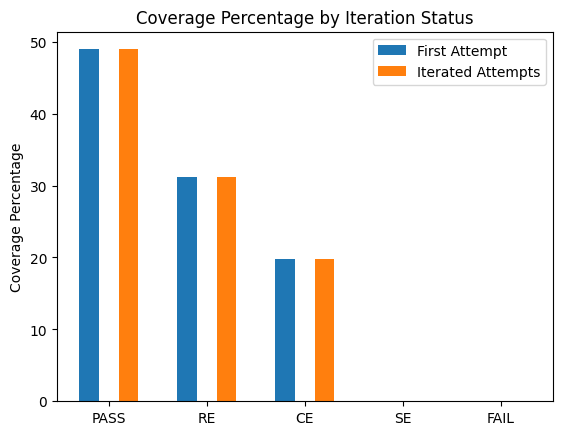

In [13]:
import matplotlib.pyplot as plt
import numpy as np

gpt4_attempts_result = calculate_percentage_and_count(gpt4_batch_li[0].attempts)

# 获取键和值
keys = list(attempts_result.keys())
first_values = [first_attempts_result[key][0] for key in keys]
# gpt4_values = [gpt4_attempts_result[key][0] for key in keys]
attempts_values = [attempts_result[key][0] for key in keys]

# 设置柱状图的位置
x = np.arange(len(keys))

# 创建一个新的图形
fig, ax = plt.subplots()

# 创建柱状图
rects1 = ax.bar(x - 0.2, first_values, 0.2, label='First Attempt')
rects2 = ax.bar(x + 0.2, attempts_values, 0.2, label='Iterated Attempts')
# rects3 = ax.bar(x, gpt4_values, 0.2, label='GPT-4')
# 添加标签，标题和自定义x轴刻度标签
ax.set_ylabel('Coverage Percentage')
ax.set_title('Coverage Percentage by Iteration Status')
ax.set_xticks(x)
ax.set_xticklabels(['PASS', 'RE', 'CE', 'SE', 'FAIL'][:len(keys)])
ax.legend()
# 设置分辨率
# fig.dpi = 200
# 显示图形
plt.show()


In [57]:
covered, total = 0, 0
def f(attempts):
    global covered, total
    print("pass method: ", len(attempts))
    for a in attempts:
        c, t = a.cover_value
        # if a.idx <= 200:
        #     no_covered = t - c
        #     t /= 2
        #     c = t - no_covered
        covered += c
        total += t

    return covered, total, covered / total

tmp_batch_li = batch_li[1:5]
# attempts = get_attempts_from_batch(tmp_batch_li, CoverageMode.BRANCH_COVERAGE)
# print(f"final: {f(get_pass_attempts(attempts))}")
attempts = get_attempts_from_batch(tmp_batch_li, CoverageMode.LINE_COVERAGE)
print(f"final: {f(get_pass_attempts(get_first_attempts(attempts)))}")
# first_attempts = get_first_attempts(attempts)

# for i in range(4):
#     print(f"iteration {i + 1}: {f(get_pass_attempts(get_iteration_n_attempts(i + 1)))}")

# pass_first_attempts = get_pass_attempts(first_attempts)
# print("first pass attempts: ", len(pass_first_attempts))
# first_cover_rate = f(pass_first_attempts)
# first_attempts_idx = [a.idx for a in pass_first_attempts]
# cover_rate = f([a for a in attempts if a.idx in first_attempts_idx])
# print("covered, total, rate")
# print(first_cover_rate)
# print(cover_rate)
# print(f"increased: {100 * (cover_rate[2] - first_cover_rate[2]):.2f}%")

focal method:  6464
pass method:  3337
final: (9885, 10881, 0.9084642955610698)


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store the coverage rate for each iteration
coverage_rates = []

# Iterate over the range of iterations
for i in range(4):
    # Calculate the coverage rate for each iteration
    _, _, rate = f(get_pass_attempts(get_iteration_n_attempts(i + 1)))
    # Append the coverage rate to the list
    coverage_rates.append(rate)

pass method:  6491
pass method:  6491
pass method:  6491
pass method:  6491


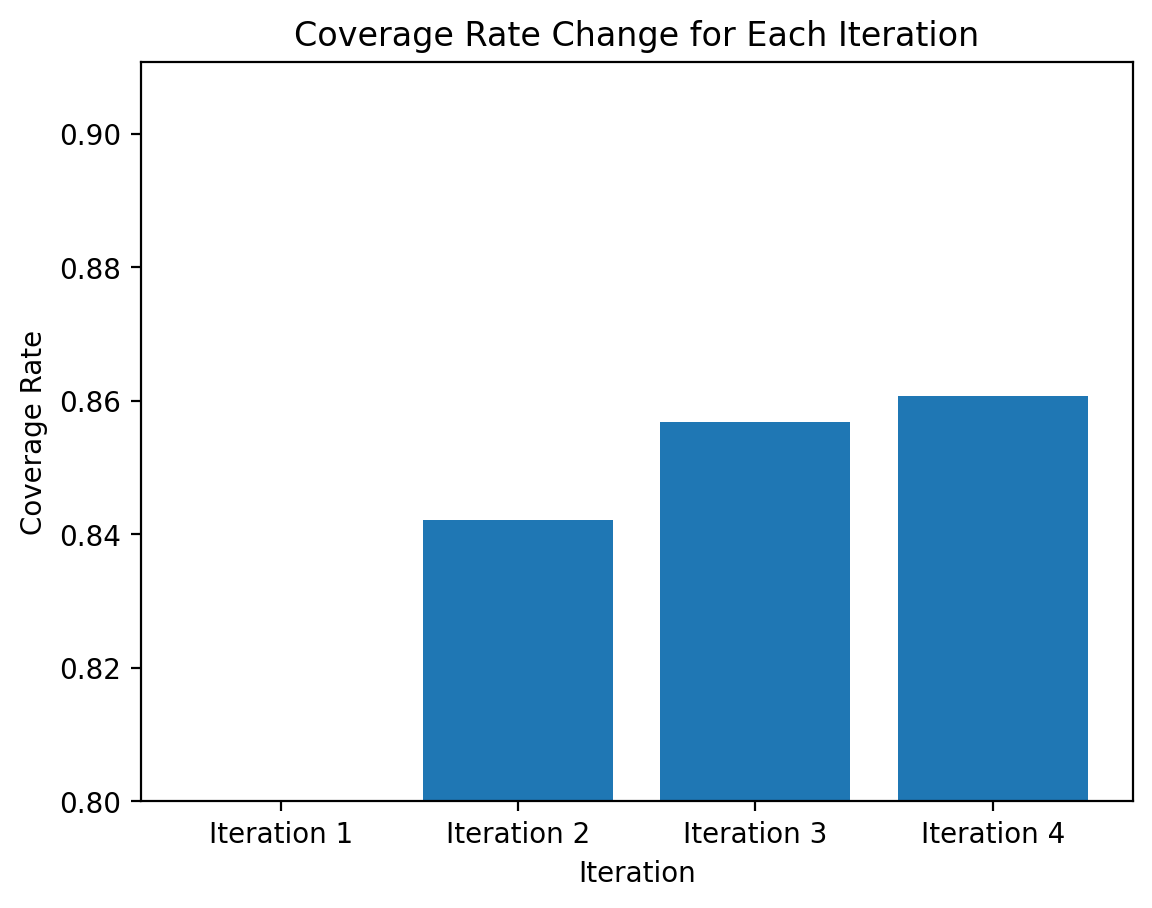

In [55]:
# Create an array for the x values
x = np.arange(1, len(coverage_rates) + 1)
plt.figure(dpi=200)

# Plot the bar chart
plt.bar(x, coverage_rates)

# Set the title and labels
plt.title('Coverage Rate Change for Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Coverage Rate')

# Set the y-axis limits
plt.ylim([0.8, max(coverage_rates) + 0.05])

# Set the x-axis tick labels to be the iteration names
iteration_names = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4']
plt.xticks(x, iteration_names)
# Show the plot
plt.show()

In [56]:
coverage_rates

[0.7704993923962734,
 0.8421966321393438,
 0.8568369886001967,
 0.8607140790463514]

focal method:  5772
test_cases_num: 8337


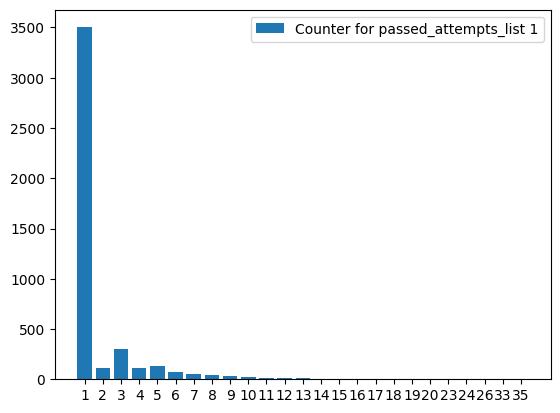

In [35]:

import matplotlib.pyplot as plt
from collections import Counter


def plot_counters(passed_attempts_list):
    for i, passed_attempts in enumerate(passed_attempts_list):
        test_cases_num = [a.iteration_status.test_status.passed for a in passed_attempts]
        print(f"test_cases_num: {sum(test_cases_num)}")
        counter = Counter(test_cases_num)
        keys = list(counter.keys())
        values = list(counter.values())
        key_value_pairs = list(zip(keys, values))
        sorted_pairs = sorted(key_value_pairs)
        sorted_keys, sorted_values = zip(*sorted_pairs)
        x_coords = range(len(sorted_keys))
        plt.bar(x_coords, sorted_values, tick_label=sorted_keys, label=f'Counter for passed_attempts_list {i + 1}')
    plt.legend()
    plt.show()


plot_counters([
    get_pass_attempts(get_attempts_from_batch(batch_li[-1:])),
])

In [61]:
a = {f"{a.clazz}#{a.method}#{a.idx}": a for a in
     get_attempts_from_batch(batch_li, CoverageMode.LINE_COVERAGE)}
print(len(a))
b = {f"{a.clazz}#{a.method}#{a.idx}": a for a in
     get_pass_attempts(get_attempts_from_batch(no_feed_back_batch_li, CoverageMode.LINE_COVERAGE))}
print(len(b))
a.update(b)
print(len(a))
a = list(a.values())

focal method:  8192
8192
focal method:  8192
6416
8192


In [1]:
def f(attempts):
    covered, total = 0, 0
    print("pass method: ", len(attempts))
    for a in attempts:
        c, t = a.cover_value
        covered += c
        total += t
    return covered, total, covered / total


attempts = get_attempts_from_batch(batch_li)

for i in range(4):
    print(f"iteration {i + 1}: {f(get_pass_attempts(get_iteration_n_attempts(i + 1)))}")
print(f"final: {f(get_pass_attempts(attempts))}")

pass_first_attempts = get_pass_attempts(first_attempts)
first_cover_rate = f(pass_first_attempts)
first_attempts_idx = [a.idx for a in pass_first_attempts]
cover_rate = f([a for a in attempts if a.idx in first_attempts_idx])
print("covered, total, rate")
print(first_cover_rate)
print(cover_rate)
print(f"increased: {100 * (cover_rate[2] - first_cover_rate[2]):.2f}%")

NameError: name 'get_attempts_from_batch' is not defined